In [1]:
# PART 1: Install Required Libraries
!pip install yfinance tensorflow scikit-learn --quiet

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# PART 2: Download Stock Data

stock_symbol = "GOOGL"
start_date = "2015-01-01"
end_date = "2024-12-31"

df = yf.download(stock_symbol, start=start_date, end=end_date)

df.head()

/tmp/ipython-input-130450842.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2015-01-02,26.278944,26.589101,26.196068,26.430299,26480000
2015-01-05,25.778229,26.201531,25.693371,26.159846,41182000
2015-01-06,25.142035,25.865070,25.087943,25.829837,54456000
2015-01-07,25.068092,25.382715,24.993656,25.355919,46918000
2015-01-08,25.155430,25.184708,24.565387,24.887454,73054000


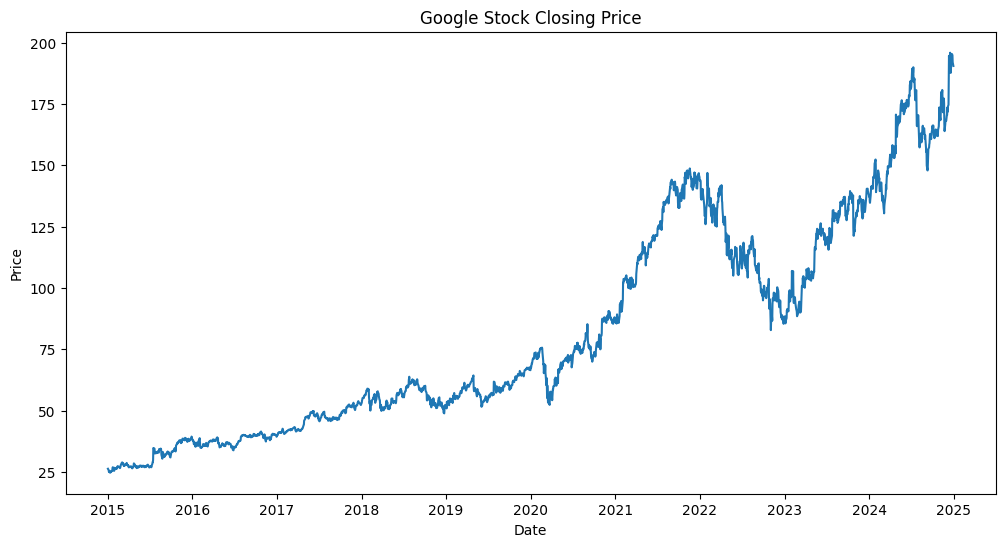

In [3]:
# PART 3: Plot Closing Prices

plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.title("Google Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [4]:
# PART 4: Prepare Data

data = df[['Close']]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

print("Scaled Data Shape:", scaled_data.shape)

Scaled Data Shape: (2515, 1)


In [5]:
# PART 5: Create Time-Series Sequences

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split 80% train, 20% test
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)

X_train shape: (1964, 60, 1)


In [6]:
# PART 6: Build LSTM Model

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# PART 7: Train Model

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0303 - val_loss: 0.0012
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0012 - val_loss: 9.5542e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 9.3776e-04 - val_loss: 0.0022
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.7593e-04 - val_loss: 0.0012
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.9298e-04 - val_loss: 0.0029
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/

In [8]:
# PART 8: Predictions

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Convert back to original prices
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [9]:
# PART 9: Evaluation Metrics

rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))
mae = mean_absolute_error(y_test_actual, test_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 11.465600181675724
MAE: 10.21543042091633


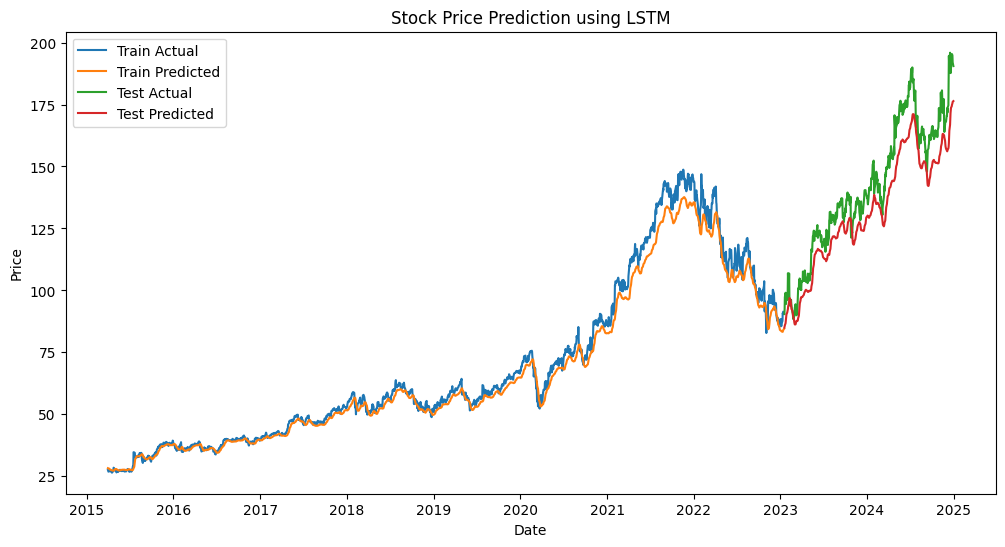

In [10]:
# PART 10: Plot Results

plt.figure(figsize=(12,6))

plt.plot(df.index[time_step:train_size+time_step], y_train_actual, label="Train Actual")
plt.plot(df.index[time_step:train_size+time_step], train_pred, label="Train Predicted")

plt.plot(df.index[train_size+time_step:], y_test_actual, label="Test Actual")
plt.plot(df.index[train_size+time_step:], test_pred, label="Test Predicted")

plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [11]:
# PART 11: Save Model

model.save("stock_lstm_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [12]:
# PART 12: Predict Next Day

last_60_days = scaled_data[-60:]
last_60_days = last_60_days.reshape(1, 60, 1)

next_day_scaled = model.predict(last_60_days)
next_day_price = scaler.inverse_transform(next_day_scaled)

print("Predicted Next Day Closing Price:", next_day_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Next Day Closing Price: 176.36484


In [16]:
from google.colab import files
files.download("stock_lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>